In [1]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import random
from tqdm import tqdm
from collections import Counter

In [2]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

In [5]:
def load_model_data(model, var, path='../data/'):
    # Loading data file
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    tas_array = ds[var].values
    # Close the dataset
    ds.close()
    return tas_array

def get_data_shape_lat_lon(model='CanESM5', var='tas', path='../data/'):
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    shape = ds[var].values.shape
    # Close the dataset
    ds.close()
    return shape, ds['lat'], ds['lon']

def load_data_models(models, var='tas', n_sample=10, path='../data/', coarse=12, window_size=10):
    X, y = None, None
    for model in models:
        tas_array = load_model_data(model, var=var, path=path)
        shape = tas_array.shape
        
        tas_regional = tas_array.reshape(shape[0], shape[1], shape[2]//coarse, coarse, shape[3]//coarse, coarse)
        X_temp = tas_regional.mean(axis=(3, 5))
        rmt = X_temp.mean(axis=0)
        # Calculate regional internal variability
        riv = rmt - X_temp
        # Create a 1D convolution kernel for the moving average
        kernel = np.ones(window_size) / window_size
        # Smooth the regional internal variability using a moving average
        A_temp = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=1, arr=riv)
            
            
        X_temp = X_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))
        y_temp = np.tile(tas_array.mean(axis=0), (shape[0], 1, 1)).reshape(shape[0]*shape[1], shape[2]*shape[3])
        A_temp = A_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))

        idxs = range(0, n_sample)

        if X is None:
            X = X_temp[idxs,:]
            y = y_temp[idxs,:]
            A = A_temp[idxs, :] 
        else :
            X = np.vstack((X, X_temp[idxs,:]))
            y = np.vstack((y, y_temp[idxs,:]))
            A = np.vstack((A, A_temp[idxs,:]))
        del tas_array
        del X_temp
        del y_temp
        del A_temp
    return A, X, y

In [6]:
shape, lat, lon = get_data_shape_lat_lon()
d = shape[2]*shape[3]

In [7]:
N = 1000
coarse=6
A_train, X_train, Y_train = load_data_models(['CanESM5'], n_sample=N, coarse=coarse)

In [9]:
plt.plot(A_train.reshape(25, 143, -1)[0, :, 0])

ValueError: cannot reshape array of size 288000 into shape (25,143,newaxis)

In [ ]:
X_test, Y_test = load_data_models(['MIROC6'], n_sample=N, coarse=coarse)

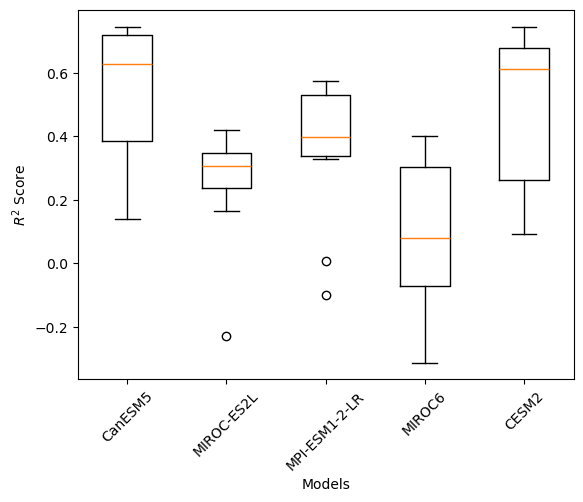

In [15]:
plt.boxplot([np.mean(scores_pattern[model], axis=1) for model in models])
# Boxplot
# Set xticklabels with alpha values
plt.xticks(range(1, len(models) + 1), [model for model in models], rotation=45)

# Set xlabel with alphas
plt.xlabel(r'Models')

# Set ylabel with r2 score
plt.ylabel(r'$R^2$ Score')

directory = '../Results'
plt.savefig(directory + "/R2_ridge_stability_coarse12.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [17]:
model = 'MIROC6'
scores_pattern_maps = np.mean(scores_pattern[model], axis=0).reshape(len(lat), len(lon))

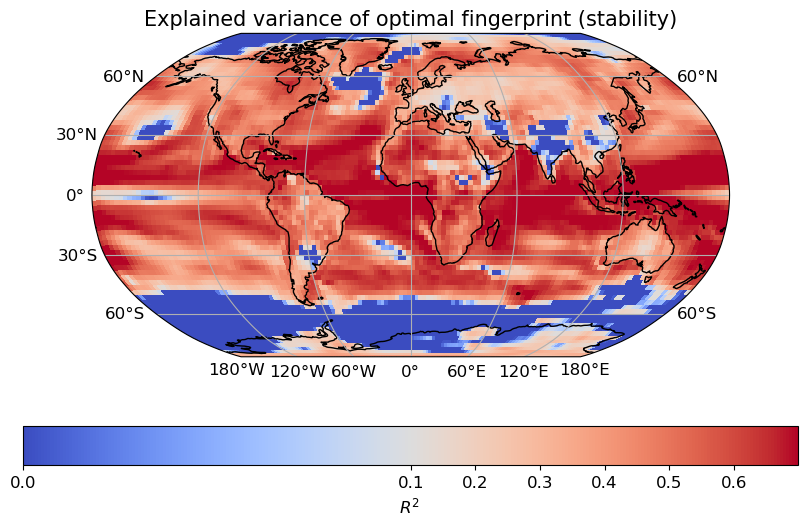

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import TwoSlopeNorm

# Assuming you have defined lat, lon, diff_r2_map, diff_corr_map, max_val_r2, max_val_corr

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Plot for diff_r2_map
norm_r2 = TwoSlopeNorm(vmin=.0, vcenter=0.1, vmax=0.7)
contour_r2 = ax.pcolormesh(lon, lat, scores_pattern_maps, transform=ccrs.PlateCarree(), cmap='coolwarm', norm=norm_r2)
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}  # Longitude font size
gl.ylabel_style = {'size': 12}  # Latitude font size

ax.set_title(r'Explained variance of optimal fingerprint (stability)', fontsize=15)

cb = plt.colorbar(contour_r2, ax=ax, label='R2 score differences', orientation='horizontal')
cb.ax.tick_params(labelsize=12)
cb.set_label(r'$R^2$ ', fontsize=12) 

directory = '../Results'
plt.savefig(directory + "/maps_R2_ridge_stability_coarse_{}_{}.pdf".format(coarse, model), format="pdf", bbox_inches="tight")


plt.show()

In [1]:
A_train

NameError: name 'A_train' is not defined